In [74]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [75]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

# 3.2) Neural Networks
- - -

In [76]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


## 3.1.1) Regression for Confirmed Cases
- - -

### Using normalized values as input and using increments as output

In [77]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [78]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [79]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [80]:
mlp = MLPRegressor(verbose=0)
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [81]:
# NOTE: hyper parameter tuning was not performed for the neural networks because it took too long to conclude.
# A simple fit and predict was made.
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 272.9603325427306
MSE: 2395589.5272708074
RMSE: 1547.769209950504
R^2: 0.036722150086413774


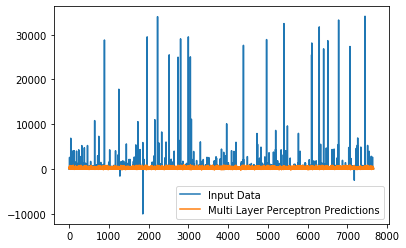

In [82]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

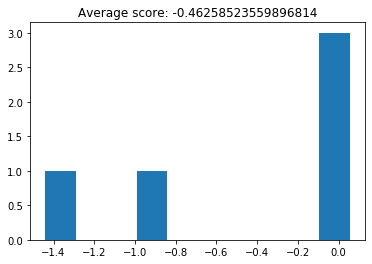

In [84]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

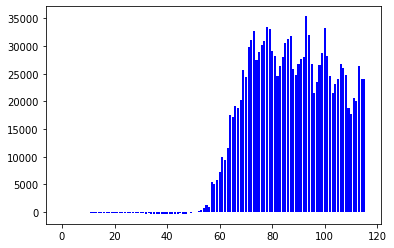

In [85]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 340355.6257221232
MSE: 329800402912.73065
RMSE: 574282.5114111787
R^2: -0.4214468569095553


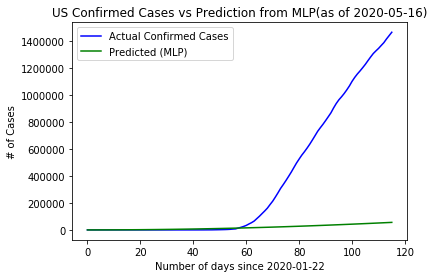

In [86]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 27845.597112659776
MSE: 3380179372.356783
RMSE: 58139.310043694044
R^2: -0.1321397965349016


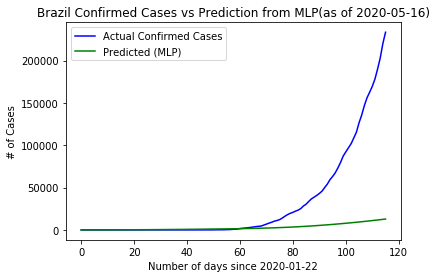

In [87]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 73483.53703520409
MSE: 12268880864.324629
RMSE: 110764.98031564231
R^2: -0.4168041914142604


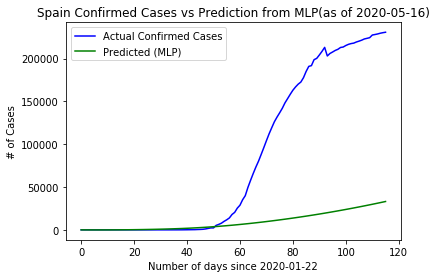

In [88]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 1830.7684997877338
MSE: 5683096.659471198
RMSE: 2383.924633764918
R^2: 0.9504930889037908


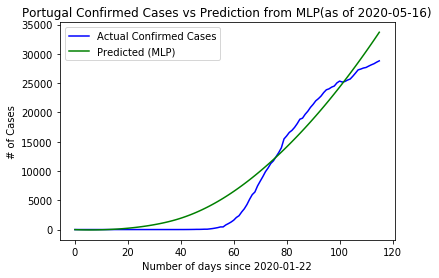

In [89]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 31848.709858203685
MSE: 4898447073.779624
RMSE: 69988.90679085953
R^2: -0.02000250936485881


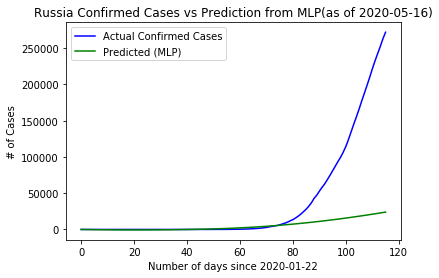

In [90]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 74124.45379683946
MSE: 11499407526.552689
RMSE: 107235.29049036371
R^2: -0.524366328670866


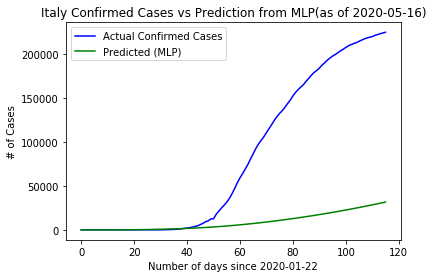

In [91]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

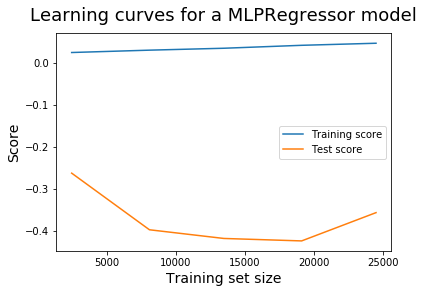

In [92]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Using non normalized values and increment in confirmed values as output


In [93]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [94]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [95]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [96]:
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 274.8248733702609
MSE: 2100240.479775397
RMSE: 1449.220645649032
R^2: 0.06529648427282919


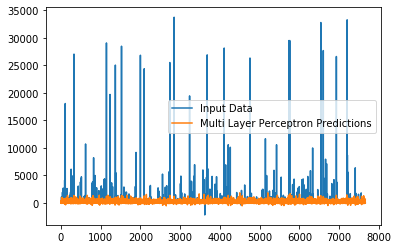

In [97]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

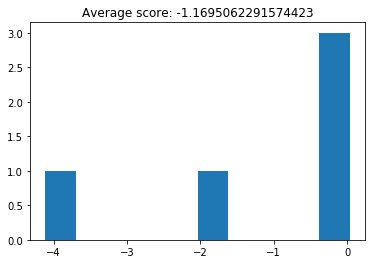

In [98]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

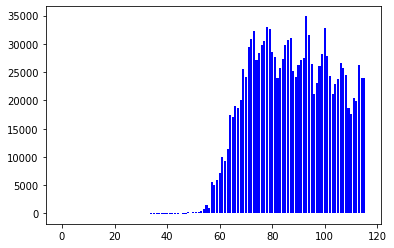

In [99]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 341060.34708262415
MSE: 328651104342.0613
RMSE: 573280.9994601785
R^2: -0.41649335525673603


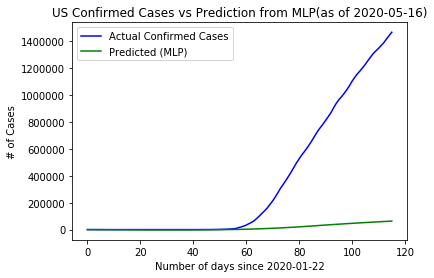

In [100]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 27441.15620466531
MSE: 2671283903.7816424
RMSE: 51684.46482050136
R^2: 0.10529398526987677


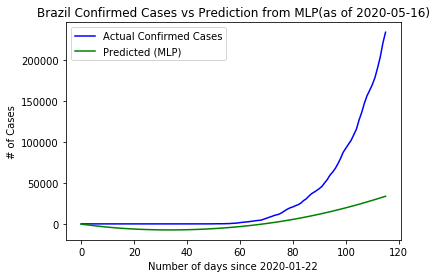

In [101]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 73311.02186953883
MSE: 12160628237.724892
RMSE: 110275.23855211056
R^2: -0.4043032325416309


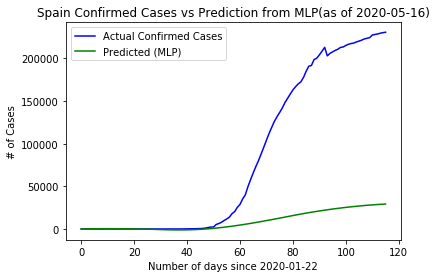

In [102]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 782.0784601040694
MSE: 1194014.6534249412
RMSE: 1092.7097754778902
R^2: 0.9895986324293524


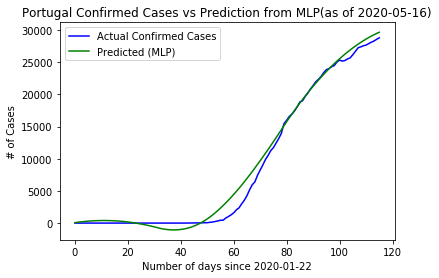

In [103]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 29321.04713077514
MSE: 3939326851.811505
RMSE: 62764.057005674076
R^2: 0.17971487421711907


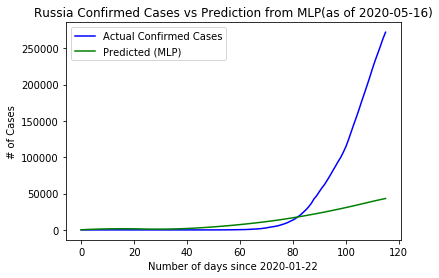

In [104]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 75093.55357198683
MSE: 11637510927.304518
RMSE: 107877.29569888428
R^2: -0.5426733739247127


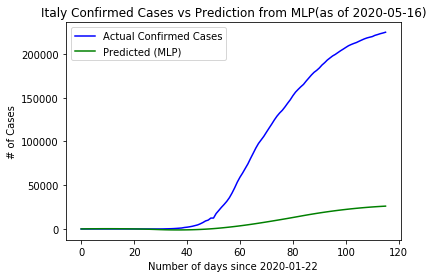

In [105]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

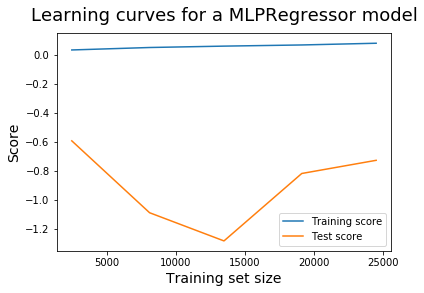

In [106]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using increase as output

In [107]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [108]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [109]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [110]:
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 42.799664726008416
MSE: 110967.50189796244
RMSE: 333.11784986392195
R^2: 0.9146333613183153


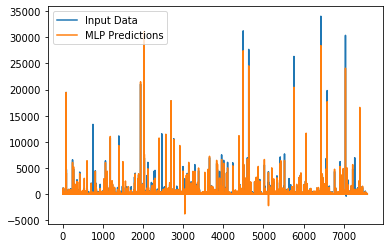

In [111]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'MLP Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

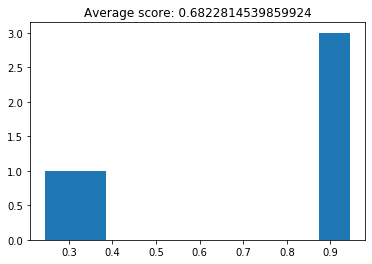

In [112]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

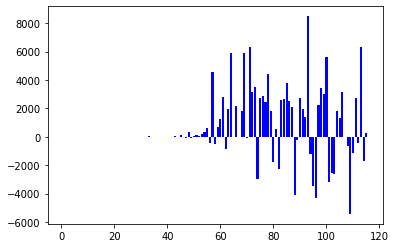

In [113]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 25497.6296000971
MSE: 1526069868.8745644
RMSE: 39064.94424512295
R^2: 0.9934482871552603


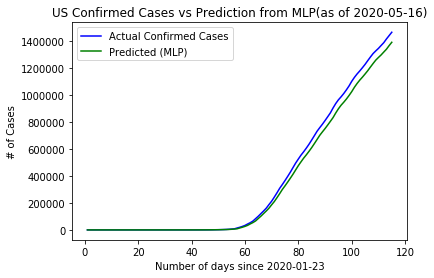

In [114]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 1528.0779743832925
MSE: 9329621.221397879
RMSE: 3054.442865957371
R^2: 0.9968937746499205


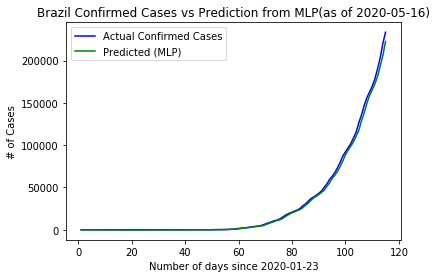

In [115]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 3054.521317076358
MSE: 20661179.26636256
RMSE: 4545.456992026496
R^2: 0.9976184056217902


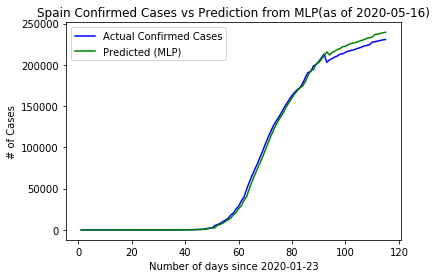

In [116]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 180.2284279403108
MSE: 74721.81072535325
RMSE: 273.352905097702
R^2: 0.9993509515090834


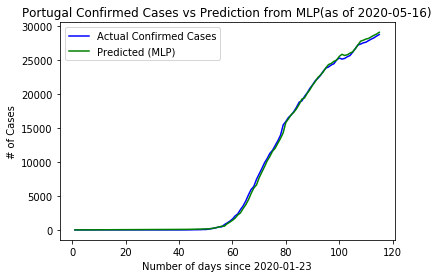

In [117]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 2378.543097505418
MSE: 18615507.2716606
RMSE: 4314.569187260832
R^2: 0.996147804131524


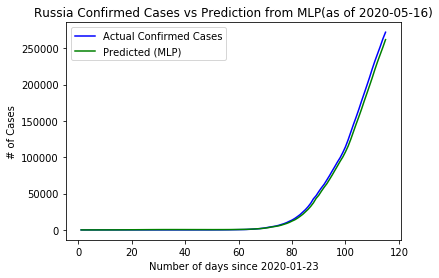

In [118]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm","Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 1382.7361617916947
MSE: 4210575.456336904
RMSE: 2051.9686782056165
R^2: 0.9994422418331088


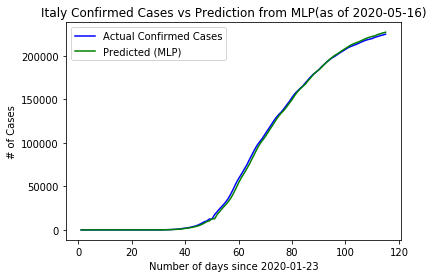

In [119]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

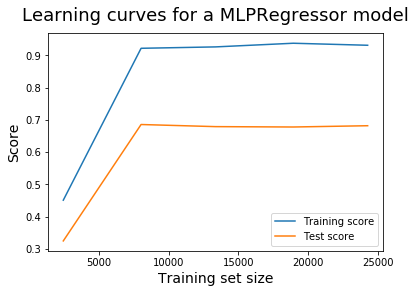

In [120]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Normalized inputs, cumulative as outputs

In [121]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [122]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [123]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [124]:
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 7906.460227017268
MSE: 1672924735.0762954
RMSE: 40901.402605244424
R^2: 0.03271276437290738


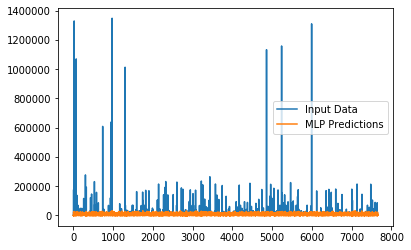

In [125]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'MLP Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

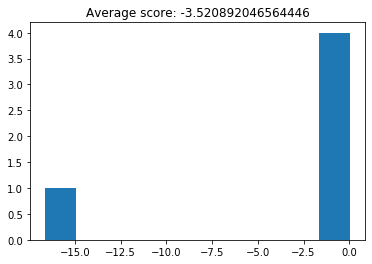

In [126]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

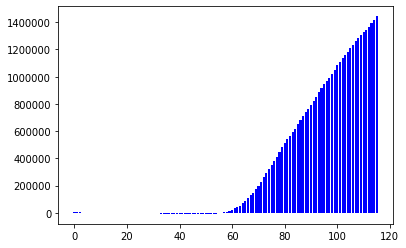

In [127]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed"
)

MAE: 347992.54531319335
MSE: 344028859673.71136
RMSE: 586539.7340962599
R^2: -0.48277181274025294


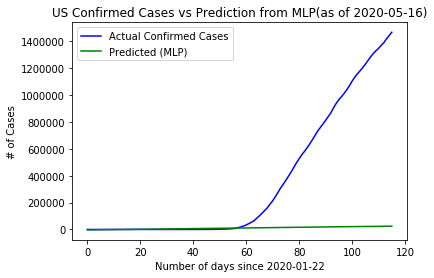

In [128]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
)

MAE: 28398.48313983915
MSE: 3492149079.2236094
RMSE: 59094.4081891308
R^2: -0.16964235104043257


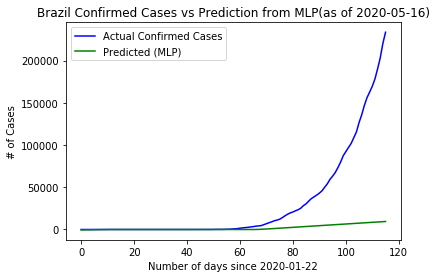

In [129]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
)

MAE: 76064.32995512
MSE: 13027148533.71364
RMSE: 114136.5346140912
R^2: -0.5043685604944235


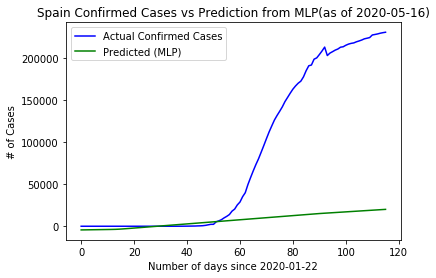

In [130]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
)

MAE: 4379.123510488461
MSE: 25447174.727951027
RMSE: 5044.519276199768
R^2: 0.7783231409927143


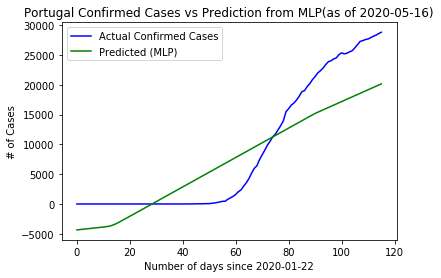

In [131]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
)

MAE: 33566.98832462083
MSE: 4962851368.433947
RMSE: 70447.50789370725
R^2: -0.03341340085186095


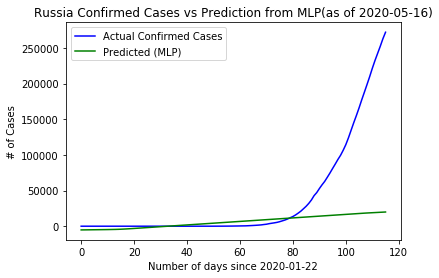

In [132]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
)

MAE: 76046.78963062586
MSE: 12073151431.401995
RMSE: 109877.89327886658
R^2: -0.6004220635261566


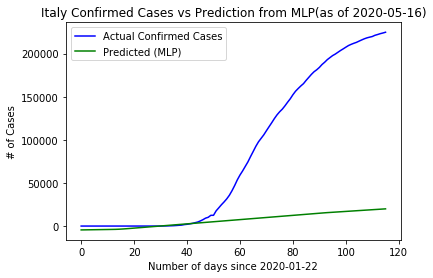

In [133]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

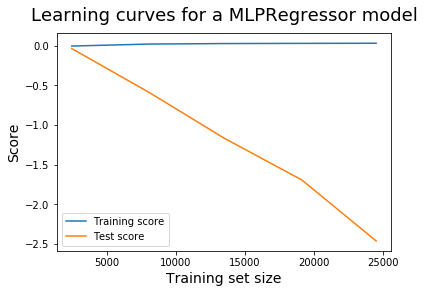

In [134]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

## 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths: for the Multi Layer Perceptron, the best option tested was using increases in confirmed cases and normalized values and using increases as output

In [135]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [136]:
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [137]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [138]:
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 4.5175266876625235
MSE: 1123.5643487241573
RMSE: 33.519611404730774
R^2: 0.8625268164728039


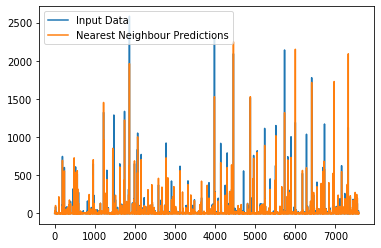

In [139]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

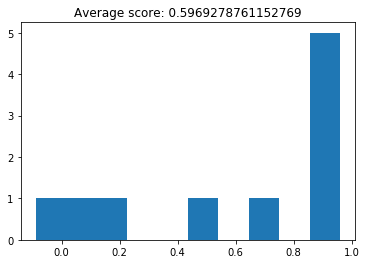

In [140]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

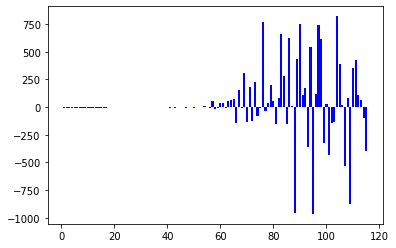

In [141]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 1119.197481687388
MSE: 3393280.140705517
RMSE: 1842.085812524899
R^2: 0.9958689656129628


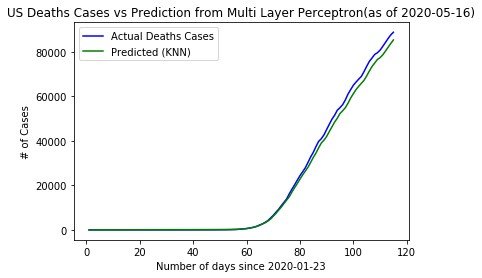

In [142]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "US Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 57.554363959074024
MSE: 5844.70716083873
RMSE: 76.45068450209409
R^2: 0.9995882323211482


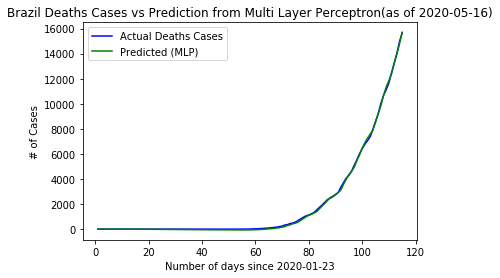

In [143]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Brazil Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 225.88016537200562
MSE: 145211.35452186727
RMSE: 381.06607631993074
R^2: 0.9987005571756141


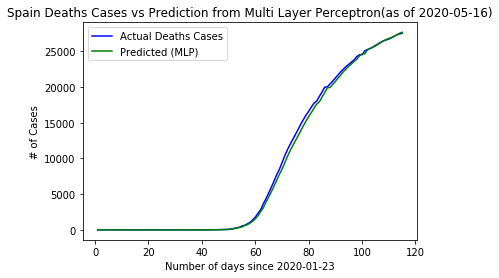

In [145]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Spain Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 65.55573126935258
MSE: 10762.66748952877
RMSE: 103.74327684013441
R^2: 0.9411220743419602


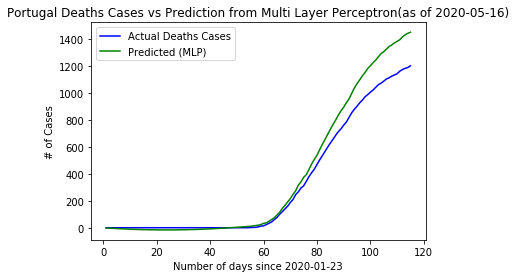

In [146]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Portugal Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 101.15128553733891
MSE: 25306.344039218155
RMSE: 159.079678272299
R^2: 0.9388671941310909


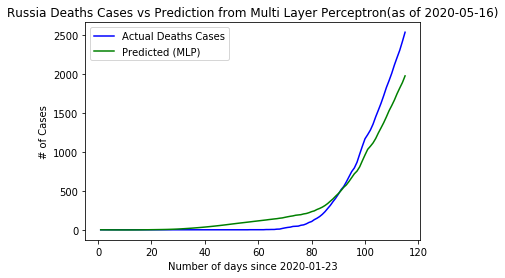

In [147]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Russia Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 523.3545936073615
MSE: 538199.9862145509
RMSE: 733.6211462427667
R^2: 0.996240815451139


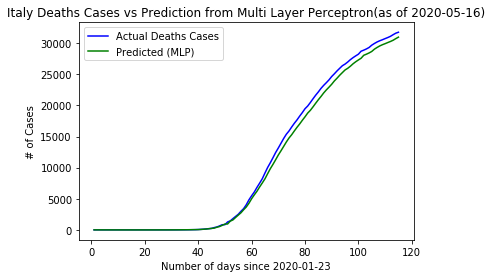

In [148]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Italy Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

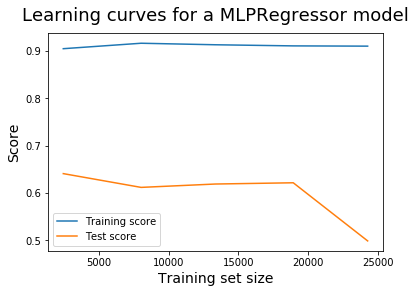

In [150]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

## 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the recovered cases: for the Multi Layer Perceptron, the best option tested was using increases in confirmed cases and normalized values and using increases as output

In [151]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [152]:
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [153]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [154]:
mlp_estimator = mlp
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 45.72270581929767
MSE: 144125.58943562457
RMSE: 379.6387617665306
R^2: 0.33703445171067936


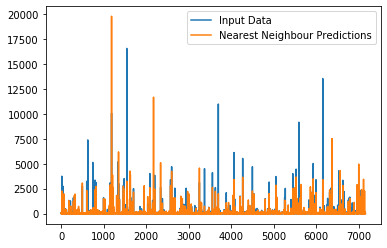

In [155]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

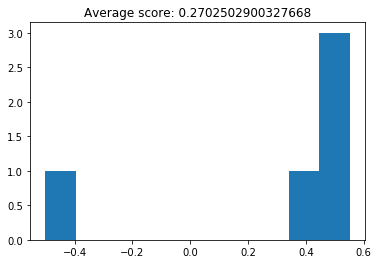

In [156]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

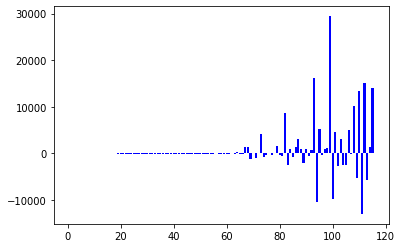

In [157]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 11600.388667365887
MSE: 565915946.7947016
RMSE: 23788.98793128244
R^2: 0.8991553612199259


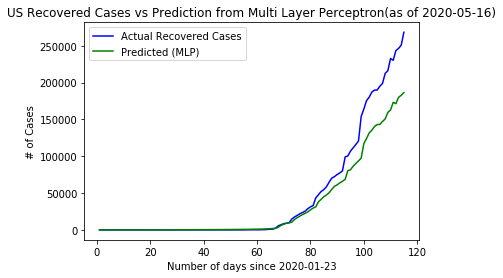

In [158]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "US Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 4047.894918992875
MSE: 65648218.90253193
RMSE: 8102.358848047396
R^2: 0.8703312122241252


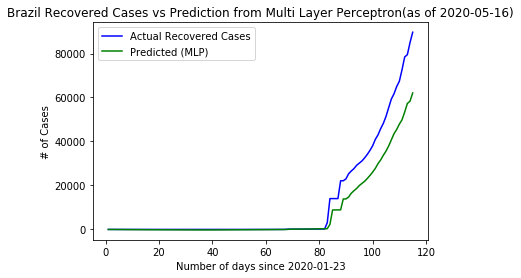

In [159]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Brazil Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 7199.373470224842
MSE: 133090696.9572389
RMSE: 11536.494136315368
R^2: 0.9456316610068891


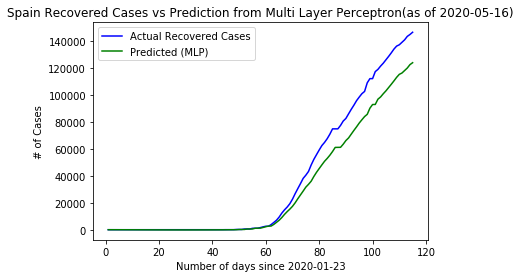

In [160]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Spain Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 460.9249705665427
MSE: 464025.45011989545
RMSE: 681.1941354121418
R^2: 0.4297047865372111


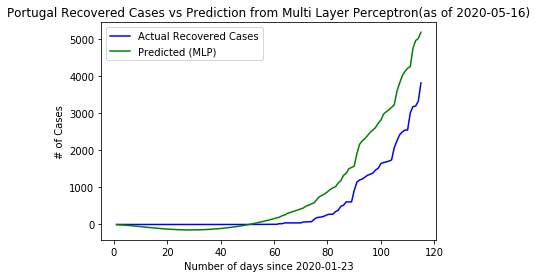

In [161]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Portugal Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 985.0280401405057
MSE: 5040564.086966686
RMSE: 2245.1200607020296
R^2: 0.9687814726708888


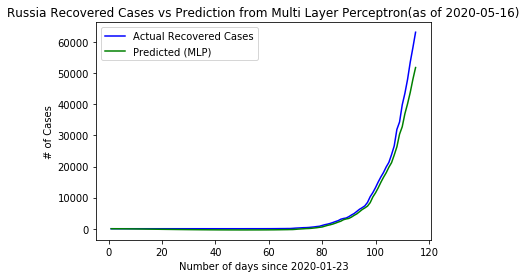

In [162]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Russia Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 2254.450622605423
MSE: 15528398.36811905
RMSE: 3940.6088829163255
R^2: 0.9878647448245415


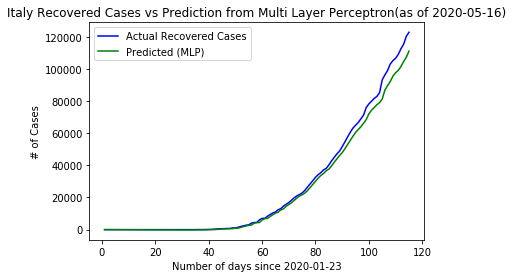

In [163]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Italy Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

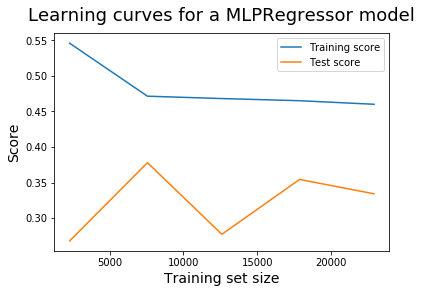

In [164]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)